In [1]:
## classification algo

## THINGS TRIED: 
#  adding age & gender 

# 1. 2-class classification with SVC & RF
# 2. finding optimal hyperparameters
# 3. checked with reduced feature set (from corr map & PCA)
# 4. changing threshold


## https://scikit-learn.org/stable/modules/svm.html
# google: how to use svm in python


# google: random forest classifier scikit learn
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/ensemble.html
# http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/

# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
# # https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65



import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

from datetime import datetime

In [2]:
######################  functions #########################

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#################################################################################

In [3]:
#################################################################################################################

### using individual epoch data ###

file_location='C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018'
os.chdir('C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018') 

In [4]:
# remove xls for 2nd night of subject 13, as there was data loss - dfull pkl file created accordingly
# read in all xls, & then the sheets

dfull = pickle.load(open('dfull_6nov.pkl', 'rb'))

In [5]:
dfull.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class
0,400,1,Seg1,1,0.703302,0.146348,0.099262,0.037832,0.018150,wake
1,400,1,Seg1,2,0.580056,0.166110,0.089898,0.058965,0.049103,wake


In [6]:
## add age & gender info

d2 = pd.read_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\SC-subjects.xls", 'Blad1')

# rename sex column: female == 1; set male == 0
#d2 = d2.rename(columns={'sex (F=1)': 'sex'})
d2['sex'] = np.where( d2['sex (F=1)'] == 2, 0, 1 )

# drop cols: night & lightsoff, old column for sex
d2 = d2.drop(['night','LightsOff','sex (F=1)'],1)

# drop extra subjects & duplicates
d2 = d2[(d2.subject < 20)]
d2['subject'] = d2['subject'] + 400
d2 = d2.drop_duplicates(subset=['subject'], keep='first')
# https://stackoverflow.com/questions/23667369/drop-all-duplicate-rows-in-python-pandas
d2['pat_id'] = d2['subject']
d2 = d2.drop('subject',1)

In [7]:
d2[['pat_id']] = d2[['pat_id']].astype('str')

d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 37
Data columns (total 3 columns):
age       20 non-null int64
sex       20 non-null int32
pat_id    20 non-null object
dtypes: int32(1), int64(1), object(1)
memory usage: 560.0+ bytes


In [8]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 10 columns):
pat_id     92994 non-null object
day        92994 non-null object
segment    92994 non-null object
epoch      92994 non-null object
delta      92994 non-null float64
theta      92994 non-null float64
alpha      92994 non-null float64
beta       92994 non-null float64
gamma      92994 non-null float64
class      92994 non-null object
dtypes: float64(5), object(5)
memory usage: 7.1+ MB


In [9]:
# merge EEG & subject details data
dfull = pd.merge(dfull, d2, how='inner', on='pat_id')  # on='subject'
dfull.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class,age,sex
0,400,1,Seg1,1,0.703302,0.146348,0.099262,0.037832,0.018150,wake,33,1
1,400,1,Seg1,2,0.580056,0.166110,0.089898,0.058965,0.049103,wake,33,1


In [10]:
dfull.describe()

,delta,theta,alpha,beta,gamma,age,sex
count,92994.000000,92994.000000,92994.000000,92994.000000,92994.000000,92994.000000,92994.000000
mean,0.548548,0.174441,0.107626,0.064444,0.051732,28.714250,0.513270
std,0.134191,0.054266,0.036677,0.030566,0.038432,2.877087,0.499827
min,0.004729,0.001743,0.001243,0.005787,0.002457,25.000000,0.000000
25%,0.465643,0.137236,0.083090,0.043786,0.024816,26.000000,0.000000
50%,0.558102,0.171532,0.103252,0.058310,0.041107,28.000000,1.000000
75%,0.643137,0.208692,0.127330,0.077500,0.066582,31.000000,1.000000
max,1.391141,0.494500,0.387486,0.333226,0.334687,34.000000,1.000000


In [11]:
dfull.groupby('class').size()

class
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [12]:
### Convert from 3-class to 2-class ####

dfull['class2'] = dfull['class']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

# wake=0 & sleepy = 1
# we want to correctly identify sleepiness
# so we want to maximise sensitivity/recall/TPR : TP/ (TP + FN)
#              proportion of actual positives/ sick people who are correctly identified as having the condition

# precision or PPV = TP/ (TP + FP) 
#              proportion of actual positives/ sick people among those which the test predicts as sick

In [13]:
dfull.dtypes

pat_id      object
day         object
segment     object
epoch       object
delta      float64
theta      float64
alpha      float64
beta       float64
gamma      float64
class       object
age          int64
sex          int32
class2       int64
dtype: object

In [14]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search

## add sex column as category

dfull[['class','sex']] = dfull[['class','sex']].astype('str')        # ,'class2'
dfull[['class','sex']] = dfull[['class','sex']].astype('category')   # ,'class2'

In [15]:
### create a smaller subset of data for testing algo
dw = dfull[(dfull['class'] == 'wake')]
d1 = dfull[(dfull['class'] == 'sleep_stage_1')]
d2 = dfull[(dfull['class'] == 'sleep_stage_2')]

# https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
# Randomly sample n elements from your dataframe
d1_elements = d1.sample(n=2800)
d2_elements = d2.sample(n=2800)
dw_elements = dw.sample(n=5600)

dn = pd.DataFrame()
dn = pd.concat([dw_elements, d1_elements, d2_elements],ignore_index=True)
dn.shape[0]

11200

In [16]:
dn.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class,age,sex,class2
0,415,2,Seg2,378,0.551187,0.160626,0.086423,0.067059,0.074128,wake,31,0,0
1,416,2,Seg8,266,0.336652,0.126742,0.061290,0.103935,0.163094,wake,32,0,0


In [17]:
## create train-test data : 2 class; with appropriate feature columns

X = dn[['delta','theta','alpha','beta','gamma','age','sex']]  # dfull[['delta','theta','alpha','beta','gamma']]
y = dn[['class2']]  # dfull[['class']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# use 'stratify=True' for consistent class distribution between training and test sets

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape

(8960, 7)

In [ ]:
#### SVC MODEL ####

In [18]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-13 10:23:49'

In [19]:
## fit model - vary ML algo & hyperparameters

model_svc = SVC()  # kernel='linear'
model_svc.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-13 10:23:51'

In [21]:
# predict on test data - check metrics
y_pred_svc = model_svc.predict(X_test_scaled)

Confusion matrix, without normalization
[[940 152]
 [179 969]]
Normalized confusion matrix
[[0.86 0.14]
 [0.16 0.84]]


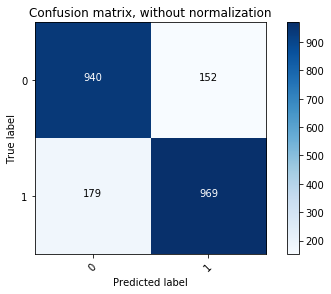

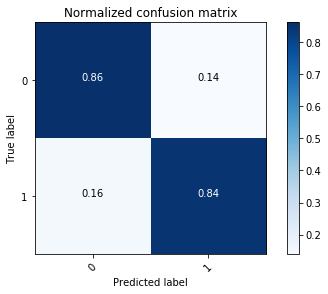

In [22]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_svc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_svc, target_names=class_names))

             precision    recall  f1-score   support

          0       0.84      0.86      0.85      1092
          1       0.86      0.84      0.85      1148

avg / total       0.85      0.85      0.85      2240



In [24]:
from sklearn.metrics import precision_recall_fscore_support
p = precision_recall_fscore_support(y_test,y_pred_svc) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.8440766550522648 , spec: 0.8608058608058609


In [ ]:
#### RF model ####

In [25]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-13 10:25:15'

In [26]:
model_rf = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-13 10:25:24'

In [28]:
# predict on test data - check metrics
y_pred_rf = model_rf.predict(X_test_scaled)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=class_names))

             precision    recall  f1-score   support

          0       0.85      0.87      0.86      1092
          1       0.87      0.86      0.86      1148

avg / total       0.86      0.86      0.86      2240



In [30]:
p = precision_recall_fscore_support(y_test,y_pred_rf) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.8571428571428571 , spec: 0.8663003663003663


Confusion matrix, without normalization
[[946 146]
 [164 984]]
Normalized confusion matrix
[[0.87 0.13]
 [0.14 0.86]]


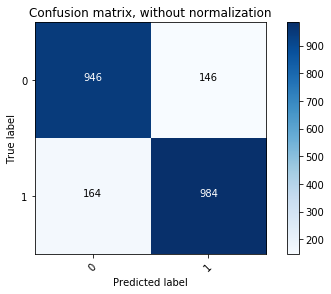

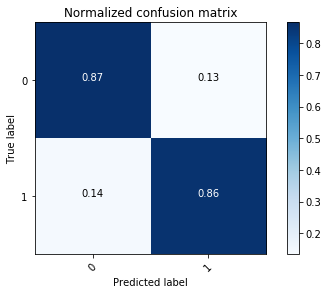

In [31]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
##############################################################################

#### grid-search to optimise RF model hyper-parameters  ###

In [42]:
'''
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = RandomForestClassifier(n_jobs=-1)  # this runs the computation in parallel

param_grid = {
    # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
    'min_samples_split': [3, 10, 20], 
    'n_estimators' : [101, 501, 1001, 5001],
    #'max_depth': [3, 5, 15, 25],
    'max_features': [2,3, 5]      # there are 5 features in the input data
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search
'''

In [43]:
'''from datetime import datetime
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))'''

2018-11-07 14:42:47


In [44]:
'''grid_search_clf = grid_search_wrapper(refit_score='recall_score')

## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
## see ln 10'''

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best params for recall_score
{'max_features': 3, 'min_samples_split': 10, 'n_estimators': 501}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       921       171
pos       176       972


In [45]:
'''print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


2018-11-07 16:32:32


In [46]:
'''
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
#results
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',  'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3)#.head()
'''

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_features,param_min_samples_split,param_n_estimators
17,0.834,0.835,0.835,3,10,501
19,0.834,0.834,0.835,3,10,5001
35,0.833,0.834,0.834,5,20,5001
31,0.831,0.834,0.833,5,10,5001
20,0.835,0.834,0.835,3,20,101
21,0.836,0.834,0.836,3,20,501
29,0.832,0.833,0.833,5,10,501
32,0.831,0.833,0.832,5,20,101
16,0.835,0.833,0.835,3,10,101
14,0.833,0.833,0.834,3,3,1001


In [32]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:26:53


In [33]:
# run optimised (parameters from previous grid search) model
model_rf_opt = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
model_rf_opt.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:27:03


In [35]:
# predict on test data - check metrics
y_pred_rf = model_rf_opt.predict(X_test_scaled)

In [36]:
from sklearn.metrics import classification_report
class_names = ['0','1']
print(classification_report(y_test, y_pred_rf, target_names=class_names))

             precision    recall  f1-score   support

          0       0.85      0.86      0.86      1092
          1       0.87      0.86      0.86      1148

avg / total       0.86      0.86      0.86      2240



In [44]:
'''## save the training & test sets
Train = pd.concat([X_train,y_train],axis=1)
Train.head(5)'''

,delta,theta,alpha,beta,gamma,age,sex,class2
2183,0.137445,0.088542,0.082937,0.140559,0.263865,31,0,0
10008,0.560685,0.204606,0.098948,0.078768,0.040780,26,1,1
2380,0.743380,0.150759,0.072873,0.028393,0.010352,33,1,0
3398,0.602454,0.158621,0.121420,0.045853,0.038335,31,1,0
10286,0.322275,0.178879,0.232524,0.157225,0.075417,28,1,1


In [45]:
'''Test = pd.concat([X_test,y_test],axis=1)
Test.head(5)'''

,delta,theta,alpha,beta,gamma,age,sex,class2
7324,0.378546,0.196310,0.185724,0.111471,0.074609,34,1,1
3193,0.601017,0.186463,0.118515,0.047116,0.024013,26,0,0
1678,0.542983,0.167992,0.090973,0.067392,0.062152,30,1,0
3318,0.501949,0.246109,0.138464,0.056151,0.024285,26,0,0
3842,0.559267,0.224304,0.149962,0.049861,0.025202,34,1,0


In [46]:
'''Train.to_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\training_data_2class_age_sex.xlsx")
Test.to_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\test_data_2class_age_sex.xlsx")  '''

In [ ]:
#######  try grid search for SVM  ######
# GOOGLE: how to perform grid search from Svm in python
# https://scikit-learn.org/stable/modules/grid_search.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html

In [60]:
'''
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC() #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVM optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search
'''

In [61]:
'''print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-07 17:20:24


In [62]:
'''grid_search_clf = grid_search_wrapper(refit_score='recall_score')

# C: penalty parameter, which represents misclassification or error term. 
# The misclassification or error term tells the SVM optimization how much error is bearable.
# This is how you can control the trade-off between decision boundary and misclassification term.
# A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane

# A lower value of Gamma will loosely fit the training dataset,
# whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting'''

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for recall_score
{'C': 1000, 'kernel': 'linear'}

Confusion matrix of SVM optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       952       140
pos       301       847


In [37]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:28:30


In [38]:
## fit model 
model_svc_opt = SVC(C=1000, kernel='linear')  # kernel='linear'
model_svc_opt.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
# predict on test data - check metrics
y_pred_svc = model_svc_opt.predict(X_test_scaled)

In [40]:
print(classification_report(y_test, y_pred_svc, target_names=class_names))

             precision    recall  f1-score   support

          0       0.76      0.87      0.81      1092
          1       0.86      0.73      0.79      1148

avg / total       0.81      0.80      0.80      2240



Confusion matrix, without normalization
[[951 141]
 [306 842]]
Normalized confusion matrix
[[0.87 0.13]
 [0.27 0.73]]


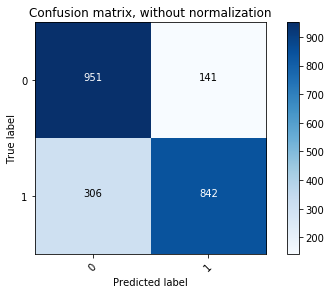

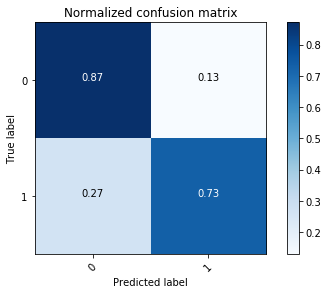

In [41]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_svc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
#########################################################################

################## corr plot  #####################

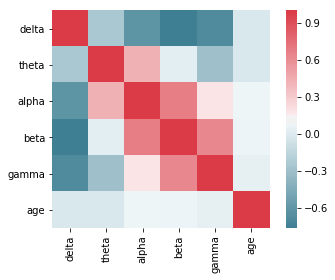

In [43]:
corr_mat = X_train.corr(method='pearson')
import seaborn as sns

f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr_mat, mask=np.zeros_like(corr_mat, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
square=True, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [44]:
######  prediction using reduced feature set  #####

X_train2 = X_train[['theta','alpha','beta','age','sex']]  
X_test2 = X_test[['theta','alpha','beta','age','sex']]

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

In [45]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:35:51


In [46]:
model_rf_cor = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_cor.fit(X_train2_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:35:59


In [48]:
# predict on test data - check metrics
y_pred = model_rf_cor.predict(X_test2_scaled)

In [49]:
print(classification_report(y_test, y_pred, target_names=class_names))

## COMMENT: RF model (n_estimators=501) withh all 5 features gave recall=0.84

             precision    recall  f1-score   support

          0       0.74      0.79      0.77      1092
          1       0.79      0.74      0.76      1148

avg / total       0.77      0.76      0.76      2240



In [50]:
#####  with derived feature set : theta/beta, alpha/beta, gamma, delta, age, sex  ######
X_train['theta_by_beta'] = X_train['theta']/X_train['beta']
X_train['alpha_by_beta'] = X_train['alpha']/X_train['beta']

X_test['theta_by_beta'] = X_test['theta']/X_test['beta']
X_test['alpha_by_beta'] = X_test['alpha']/X_test['beta']

X_train.head(1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,delta,theta,alpha,beta,gamma,age,sex,theta_by_beta,alpha_by_beta
2183,0.551327,0.17186,0.141176,0.072355,0.036237,31,0,2.37522,1.951146


In [51]:
######  prediction using reduced feature set  #####

X_train3 = X_train[['theta_by_beta','alpha_by_beta','gamma','delta','age','sex']]  
X_test3 = X_test[['theta_by_beta','alpha_by_beta','gamma','delta','age','sex']]

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.transform(X_test3)

In [52]:
model_rf_cor = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_cor.fit(X_train3_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
# predict on test data - check metrics
y_pred = model_rf_cor.predict(X_test3_scaled)

In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

## COMMENT: RF model (n_estimators=501) withh all 5 features gave recall=0.84

             precision    recall  f1-score   support

          0       0.83      0.80      0.82      1092
          1       0.82      0.84      0.83      1148

avg / total       0.82      0.82      0.82      2240



In [ ]:
####################################################################

#################   pca   ########################

In [55]:
X_train.head(1)

,delta,theta,alpha,beta,gamma,age,sex,theta_by_beta,alpha_by_beta
2183,0.551327,0.17186,0.141176,0.072355,0.036237,31,0,2.37522,1.951146


In [56]:
X_train = X_train.drop(['theta_by_beta','alpha_by_beta'], 1)
X_test = X_test.drop(['theta_by_beta','alpha_by_beta'], 1)

X_train.head(1)

,delta,theta,alpha,beta,gamma,age,sex
2183,0.551327,0.17186,0.141176,0.072355,0.036237,31,0


In [57]:
from sklearn import decomposition
pca = decomposition.PCA()  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(pca.explained_variance_ratio_)

[9.70e-01 2.71e-02 2.35e-03 4.01e-04 1.22e-04 4.61e-05 2.55e-05]


In [58]:
## predict using 1st two PCs
from sklearn import decomposition
pca = decomposition.PCA(n_components = 2)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [59]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:39:50


In [60]:
model_rf_pc = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_pc.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-13 10:39:58


In [62]:
# predict on test data - check metrics
y_pred = model_rf_pc.predict(X_test_pca)

In [63]:
print(classification_report(y_test, y_pred, target_names=class_names))

## COMMENT: RF model (n_estimators=501) withh all 5 features gave recall=0.84

             precision    recall  f1-score   support

          0       0.68      0.68      0.68      1092
          1       0.69      0.69      0.69      1148

avg / total       0.68      0.68      0.68      2240



In [64]:
## predict using 1st 3 PCs
from sklearn import decomposition

pca = decomposition.PCA(n_components = 3)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [65]:
model_rf_pc = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_pc.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
y_pred = model_rf_pc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.70      0.69      0.69      1092
          1       0.71      0.71      0.71      1148

avg / total       0.70      0.70      0.70      2240



In [67]:
## predict using 1st 5 PCs
from sklearn import decomposition

pca = decomposition.PCA(n_components = 5)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [68]:
model_rf_pc = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_pc.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
y_pred = model_rf_pc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76      1092
          1       0.77      0.77      0.77      1148

avg / total       0.76      0.76      0.76      2240



In [70]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 3)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [71]:
## plot PCA-transformed data

principalDf = pd.DataFrame(data = X_train_pca
             , columns = ['PC 1', 'PC 2', 'PC 3'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

In [72]:
finalDf.head(2)

,PC 1,PC 2,PC 3,class2
0,2.180778,0.604758,0.040727,0.0
1,3.180137,0.639810,0.055406,0.0


In [73]:
finalDf.dtypes

PC 1      float64
PC 2      float64
PC 3      float64
class2    float64
dtype: object

In [16]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

#fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('Principal Component 1', fontsize = 15)
#ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)

#targets = ['0', '1']
#colors = ['r', 'b']
#for target, color in zip(targets,colors):
#    indicesToKeep = finalDf['class2'] == target
#    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
#               , finalDf.loc[indicesToKeep, 'PC 2']
#               , c = color
#               , s = 50)
#ax.legend(targets)
#ax.grid()

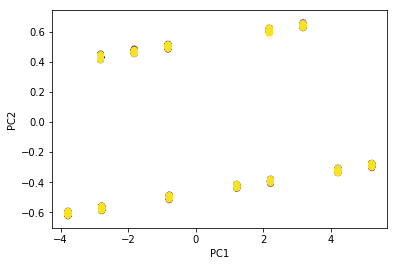

In [74]:
plt.scatter(finalDf['PC 1'], finalDf['PC 2'], alpha=0.2, c=finalDf['class2'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

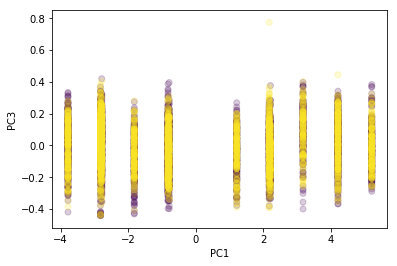

In [75]:
plt.scatter(finalDf['PC 1'], finalDf['PC 3'], alpha=0.2, c=finalDf['class2'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

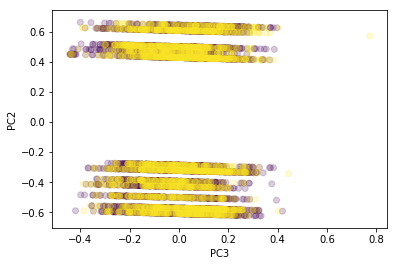

In [76]:
plt.scatter(finalDf['PC 3'], finalDf['PC 2'], alpha=0.2, c=finalDf['class2'], cmap='viridis')
plt.xlabel('PC3')
plt.ylabel('PC2')
plt.show()

In [ ]:
#################################################3############################## 
#########    feature importance: with the full set of features   ##########

In [77]:
model_rf = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
model_rf.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

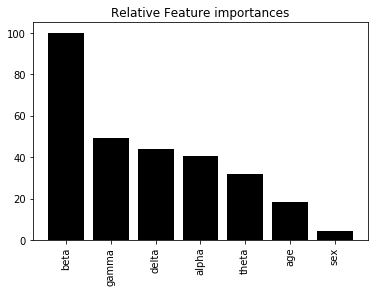

In [78]:
importances_rf = model_rf.feature_importances_

FI_rf = 100.0 * (importances_rf / importances_rf.max())
labels = X_train.columns
indices = np.argsort(FI_rf)[::-1]
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative Feature importances")
plt.bar(labels[indices], FI_rf[indices], color="black", align="center")   #
plt.xticks(labels[indices], rotation='vertical')
plt.show()

In [ ]:
#######################################################################

#######  change threshold ########

# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [79]:
# this is for the svc grid search
#y_scores = grid_search_clf.decision_function(X_test) # .predict_proba(X_test)[:, 1]

# for optimised SVC
y_scores = model_svc_opt.decision_function(X_test_scaled)

In [80]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [81]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)



     pred_neg  pred_pos
neg       995        97
pos       388       760


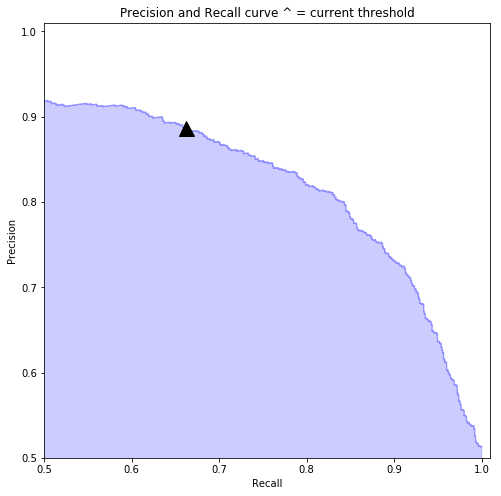

In [82]:
precision_recall_threshold(p, r, thresholds, 0.30)

In [83]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

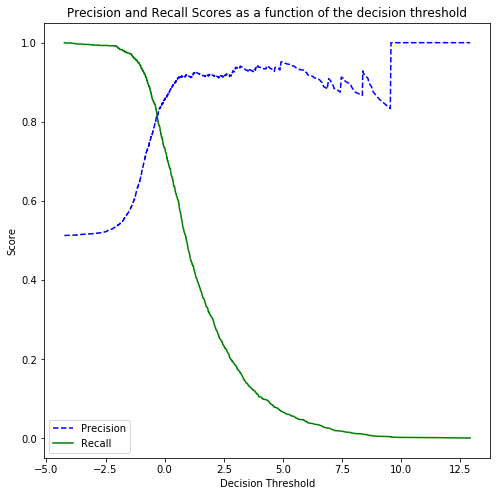

In [84]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [85]:
y_pred_adj = adjusted_classes(y_scores, 0.3)
print(classification_report(y_test, y_pred_adj, target_names=class_names))

             precision    recall  f1-score   support

          0       0.72      0.91      0.80      1092
          1       0.89      0.66      0.76      1148

avg / total       0.81      0.78      0.78      2240



In [86]:
# this is for the RF model
y_scores = model_rf_opt.predict_proba(X_test_scaled)[:, 1]

In [87]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

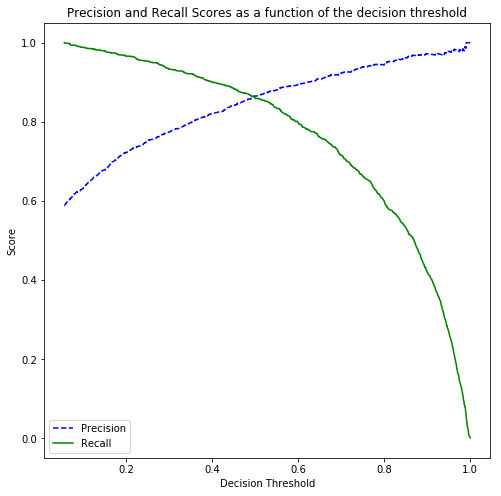

In [88]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [89]:
y_pred_adj = adjusted_classes(y_scores, 0.3)
print(classification_report(y_test, y_pred_adj, target_names=class_names))

# this has better performance than similar threshold change without age & sex, but no improvement compared to defaults

             precision    recall  f1-score   support

          0       0.91      0.71      0.80      1092
          1       0.77      0.93      0.85      1148

avg / total       0.84      0.83      0.82      2240



In [90]:
y_pred_adj = adjusted_classes(y_scores, 0.2)
print(classification_report(y_test, y_pred_adj, target_names=class_names))

             precision    recall  f1-score   support

          0       0.94      0.61      0.74      1092
          1       0.72      0.97      0.83      1148

avg / total       0.83      0.79      0.79      2240



In [91]:
y_pred_adj = adjusted_classes(y_scores, 0.4)
print(classification_report(y_test, y_pred_adj, target_names=class_names))

             precision    recall  f1-score   support

          0       0.88      0.79      0.84      1092
          1       0.82      0.90      0.86      1148

avg / total       0.85      0.85      0.85      2240



In [ ]:
### compare perfomance on training & test sets ###

In [3]:

Train = pd.read_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\training_data_2class_age_sex.xlsx")
Test = pd.read_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\test_data_2class_age_sex.xlsx")
X_train = Train[['delta','theta','alpha','beta','gamma','age','sex']]
X_test = Test[['delta','theta','alpha','beta','gamma','age','sex']]
y_train = Train[['class2']]
y_test = Test[['class2']]


## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  # MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape

(8960, 7)

In [4]:
model_rf = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
y_pred_rf = model_rf.predict(X_test_scaled)

from sklearn.metrics import classification_report
class_names = ['0','1']
print(classification_report(y_test, y_pred_rf, target_names=class_names))
## these values are lower than for training set - so there is scope for improvement

             precision    recall  f1-score   support

          0       0.85      0.86      0.85      1092
          1       0.86      0.85      0.86      1148

avg / total       0.86      0.86      0.86      2240



In [7]:
# on training data
y_train_pred = model_rf.predict(X_train_scaled)

print(classification_report(y_train, y_train_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4508
          1       1.00      1.00      1.00      4452

avg / total       1.00      1.00      1.00      8960



In [ ]:
## plots for training & test set error


In [ ]:
##################################################################################################################

########################  INCREASING DATASET SIZE , iterations  #################################################